## Загрузка датасета

In [1]:
import pandas as pd
import numpy as np

In [2]:
FILE_TYPE = 'csv'
df_original = []
if FILE_TYPE == 'xlsx':
    HABR_DATASET_PATH = 'habr.xlsx'
    df_original = pd.read_excel(HABR_DATASET_PATH)
elif FILE_TYPE == 'csv':
    HABR_DATASET_PATH = 'vacancies_data.csv'
    df_original = pd.read_csv(HABR_DATASET_PATH, encoding='utf8')

In [3]:
df_original

,Ссылка на объявление,Дата размещения,Название,Зарплата от,Зарплата до,Валюта,Вакансия,Стаж,Требования,Город,Тип занятости,Можно удаленно,Описание,Работодатель,Ссылка на работодателя,Рейтинг,Офисы,Число сотрудников,Дата сбора данных
0,https://career.habr.com/vacancies/1000144781,2024-06-27 16:50:48,Архитектор серверной инфраструктуры,NaN,500000.0,₽,Архитектор программного обеспечения,Старший (Senior),JavaScript / Node.js / Python / Elasticsearch ...,Москва,Полный рабочий день,NaN,~~~ О компании и команде\nО нас: Амбициозная к...,Ваша кадровая служба,https://vks.agency,NaN,"Россия, Москва, ул. Атарбекова, д. 4",0.0,2024-07-01 23:06:03
1,https://career.habr.com/vacancies/1000139937,2024-06-28 10:40:49,Руководитель группы FI/CO/FM,NaN,NaN,NaN,Менеджер технической поддержки,NaN,SAP / ABAP,Москва,Полный рабочий день,True,~~~ О компании и команде\nМеждународная сеть м...,Fix Price,https://fix-price.ru/,NaN,"Россия, Москва, Щепкина, д.33",2.0,2024-07-01 23:06:03
2,https://career.habr.com/vacancies/1000143735,2024-06-04 16:24:59,Intern Project Manager,5000.0,25000.0,₽,Менеджер проекта,Стажёр (Intern),Управление проектами / Agile / Управление риск...,"Москва, Санкт-Петербург, Казань",Полный рабочий день,True,~~~ О компании и команде\nКомпания FedAG - быс...,FedAG,https://career.habr.com/companies/fedag,4.90,"Россия, Санкт-Петербург, Институтский переулок 5",1.0,2024-07-01 23:06:04
3,https://career.habr.com/vacancies/1000143869,2024-07-01 12:09:30,"Middle+ Backend (Node.js, TypeScript) Developer",210000.0,NaN,₽,Бэкенд разработчик,Средний (Middle),Node.js / TypeScript / MongoDB / Redis,NaN,Полный рабочий день,True,~~~ О компании и команде\nОптимакрос – крупный...,Optimacros,https://optimacros.com,NaN,"Россия, Москва, Дмитровское шоссе, 81",0.0,2024-07-01 23:06:04
4,https://career.habr.com/vacancies/1000144076,2024-06-25 19:33:45,Системный аналитик,NaN,NaN,NaN,Системный аналитик,NaN,SQL / REST,NaN,NaN,True,~~~ О компании и команде\nОбязанности: Наша ко...,IBS,http://www.ibs.ru/,4.38,"Россия, Омск, ул. Маяковского, 74А\nРоссия, Ша...",12.0,2024-07-01 23:06:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,https://career.habr.com/vacancies/1000144598,2024-06-26 11:03:21,Ведущий программист 1C,NaN,250000.0,₽,Программист 1С,Старший (Senior),Разработка под 1С,NaN,Полный рабочий день,True,"~~~ О компании и команде\nКрафтье Компания """" ...",Bullevie,https://bullevie.ru/,NaN,"Россия, Санкт-Петербург, гп.Федоровское, ул.Пр...",0.0,2024-07-01 23:23:50
3195,https://career.habr.com/vacancies/1000143341,2024-06-25 17:01:12,Software Architect (NGFW),NaN,NaN,NaN,Архитектор программного обеспечения,NaN,Разработка программного обеспечения / Проектир...,NaN,NaN,True,~~~ О компании и команде\nNext Generation Fire...,Лаборатория Касперского,https://kaspersky.ru/,4.20,"Россия, Москва, Ленинградское ш., д. 39А, стр....",7.0,2024-07-01 23:23:50
3196,https://career.habr.com/vacancies/1000144180,2024-06-28 14:36:00,Data Center Infrastructure Engineer / Инженер ...,NaN,NaN,NaN,Системный администратор,Средний (Middle),Администрирование Linux / Bash / Osi model,Санкт-Петербург,Полный рабочий день,NaN,~~~ О компании и команде\nYADRO — это российск...,YADRO,https://yadro.com,NaN,"Россия, Москва, ул. Рочдельская, д. 15, стр. 1...",5.0,2024-07-01 23:23:50
3197,https://career.habr.com/vacancies/1000141715,2024-07-01 12:23:49,Ведущий инженер OpenStack,NaN,NaN,NaN,Инженер по доступности сервисов,Старший (Senior),Linux / Ansible / Terraform,Москва,Полный рабочий день,NaN,~~~ О компании и команде\nМы привлекаем амбици...,Cloud.ru,https://cloud.ru,4.75,"Россия, Москва, ул. 2-я Звенигородская, д. 28",4.0,2024-07-01 23:23:51


## Предобработка датасета

In [5]:
valide_cols = [
    'Дата размещения',
    'Вакансия',
    'Стаж',
    'Зарплата от',
    'Зарплата до',
    'Город',
    'Дата сбора данных',
    'Число сотрудников',
    'Тип занятости',
    'Можно удаленно',
]
def get_valide_cols(dataset, cols):
    return dataset[cols]

In [6]:
exchange_rate_template = {
    "₽": 1,
    "$": 92.37,
    "€": 99.53,
    "₸": 0.206
}
def apply_exchange_rate(row, template=exchange_rate_template):
    row["Зарплата от"] = row["Зарплата от"] * exchange_rate_template[row["Валюта"]] if pd.notna(row["Зарплата от"]) else np.nan
    row["Зарплата до"] = row["Зарплата до"] * exchange_rate_template[row["Валюта"]] if pd.notna(row["Зарплата до"]) else np.nan
    return row

In [7]:
def get_difference_percentiles(df):
    filtered_df = df.dropna(subset=['Зарплата от', 'Зарплата до']).copy()
    filtered_df['Разница'] = filtered_df['Зарплата до'] - filtered_df['Зарплата от']
    condition = filtered_df['Разница'] > 0.8 * filtered_df['Зарплата до']
    filtered_df.loc[condition, ['Зарплата от', 'Разница']] = np.nan

    filtered_df = filtered_df.dropna(subset=['Зарплата от', 'Зарплата до'])

    filtered_df = filtered_df[filtered_df['Зарплата от'] >= 1000]
    filtered_df = filtered_df[filtered_df['Зарплата до'] >= 10000]

    filtered_df['Коэффициент разницы'] = np.where(filtered_df['Зарплата до'] != 0,
                                                      filtered_df['Разница'] / filtered_df['Зарплата до'],
                                                      np.nan)

    perc25 = filtered_df['Коэффициент разницы'].quantile(0.25)
    perc50 = filtered_df['Коэффициент разницы'].quantile(0.50)
    perc75 = filtered_df['Коэффициент разницы'].quantile(0.75)

    return perc25, perc50, perc75


def fill_na_salary(df, coef):
    result_df = df.copy()
    result_df['Зарплата до'] = result_df['Зарплата до'].fillna(result_df['Зарплата от'] / (1-coef))
    result_df['Зарплата от'] = result_df['Зарплата от'].fillna(result_df['Зарплата до'] * (1-coef))
    return result_df

In [8]:
import re

def separate_cities(df):
  work_df = df.copy()
  df_new = pd.DataFrame()
  for index in range(work_df.shape[0]):
    row = re.sub("[\(\[].*?[\)\]]", "", work_df['Город'].iloc[index])
    cities = [city.lstrip().rstrip() for city in row.split(',')]
    init_row = work_df.iloc[index].copy()
    for city in cities:
      new_row = init_row.copy()
      new_row['Город'] = city
      df_new = pd.concat([df_new, pd.DataFrame([new_row])], ignore_index=True)
  return df_new

def find_cities_around_threshold(df, threshold=75):
  cities = df['Город'].unique()
  ratios = {}
  for city in cities:
    ratios[city] = df['Город'].value_counts()[city]/df.shape[0]

  answer = []
  all_percentage = 0
  sorted_dict = {k: v for k, v in sorted(ratios.items(), key=lambda item: item[1], reverse=True)}
  for label, pct in sorted_dict.items():
      all_percentage += pct*100
      if all_percentage < threshold:
          answer.append(label)
  return answer

def create_new_cities(df, cities):
  df_new = df.copy()
  for index in range(df_new.shape[0]):
    if (df_new.iloc[index]['Город'] not in cities):
      df_new.at[index, 'Город'] = 'Малый город'
  return df_new

In [9]:
def fillna_experience_with_vacancy(df):
    dataset = df.copy()

    mean_wages = dataset.groupby(['Вакансия', 'Стаж']).agg({'Зарплата от': 'mean', 'Зарплата до': 'mean'}).reset_index()
    mean_wages['Средняя зарплата'] = (mean_wages['Зарплата от'] + mean_wages['Зарплата до']) / 2

    for i, row in dataset.iterrows():
        if pd.isna(row['Стаж']):
            min_wage = row['Зарплата от']
            max_wage = row['Зарплата до']
            avg_wage = (min_wage + max_wage) / 2
            vacancy_name = row['Вакансия']

            closest_experience = None
            smallest_diff = float('inf')
            for _, r in mean_wages[mean_wages['Вакансия'] == vacancy_name].iterrows():
                wage_diff = abs(avg_wage - r['Средняя зарплата'])
                if wage_diff < smallest_diff:
                    smallest_diff = wage_diff
                    closest_experience = r['Стаж']

            dataset.loc[i, "Стаж"] = closest_experience

    return dataset


def fillna_experience_with_wages(df):
    dataset = df.copy()

    mean_wages = dataset.groupby(['Стаж']).agg({'Зарплата от': 'mean', 'Зарплата до': 'mean'}).reset_index()
    mean_wages['Средняя зарплата'] = (mean_wages['Зарплата от'] + mean_wages['Зарплата до']) / 2

    for i, row in dataset.iterrows():
        if pd.isna(row['Стаж']):
            min_wage = row['Зарплата от']
            max_wage = row['Зарплата до']
            avg_wage = (min_wage + max_wage) / 2

            closest_experience = None
            smallest_diff = float('inf')
            for _, r in mean_wages.iterrows():
                wage_diff = abs(avg_wage - r['Средняя зарплата'])
                if wage_diff < smallest_diff:
                    smallest_diff = wage_diff
                    closest_experience = r['Стаж']

            dataset.loc[i, "Стаж"] = closest_experience

    return dataset

In [10]:
def preprocessing_data(df):
   df_new = df.copy()

   missing_data = df_new[df["Зарплата от"].isnull() & df_new["Зарплата до"].isnull()]
   df_new = df_new.drop(missing_data.index)

   df_new['Можно удаленно'].fillna(0, inplace=True)
   df_new['Можно удаленно'] = df_new['Можно удаленно'].astype('int64')
   df_new['Можно удаленно'] = df_new['Можно удаленно'].apply(lambda x: "Да" if x == 1 else "Нет")

   df_new.loc[(df_new['Можно удаленно'] == "Нет") & (df_new['Город'].isnull()), 'Город'] = 'Не указано'
   df_new.loc[(df_new['Можно удаленно'] == "Да") & (df_new['Город'].isnull()), 'Город'] = 'Удаленно'

   df_new['Тип занятости'].fillna('Не указан', inplace=True)

   df_new['Число сотрудников'].fillna(0, inplace=True)
   df_new['Число сотрудников'] = df_new['Число сотрудников'].astype('int64')

   df_new = df_new.apply(apply_exchange_rate, axis=1)
   df_new.drop("Валюта", axis=1, inplace=True)

   perc25, perc50, perc75 = get_difference_percentiles(df_new)
   df_filled_salary = fill_na_salary(df_new, perc50)

   # df_exp = fillna_experience_with_vacancy(df_25)

   df_result = get_valide_cols(df_filled_salary, valide_cols)
   return df_result

In [11]:
df_prep = preprocessing_data(df_original)
# df_exp_vac = fillna_experience_with_vacancy(df_prep)
df_exp = fillna_experience_with_wages(df_prep) # fillna_experience_with_wages(df_exp_vac)

In [22]:
df_exp

,Дата размещения,Вакансия,Стаж,Зарплата от,Зарплата до,Город,Дата сбора данных,Число сотрудников,Тип занятости,Можно удаленно
0,2024-06-27 16:50:48,Архитектор программного обеспечения,Старший (Senior),333333.333333,500000.0,Москва,2024-07-01 23:06:03,0,Полный рабочий день,Нет
2,2024-06-04 16:24:59,Менеджер проекта,Стажёр (Intern),5000.000000,25000.0,"Москва, Санкт-Петербург, Казань",2024-07-01 23:06:04,1,Полный рабочий день,Да
3,2024-07-01 12:09:30,Бэкенд разработчик,Средний (Middle),210000.000000,315000.0,Удаленно,2024-07-01 23:06:04,0,Полный рабочий день,Да
8,2024-06-04 09:23:18,Менеджер по найму,Стажёр (Intern),66666.666667,100000.0,Удаленно,2024-07-01 23:06:06,0,Полный рабочий день,Да
18,2024-06-06 13:34:21,Менеджер технической поддержки,Средний (Middle),60000.000000,90000.0,Удаленно,2024-07-01 23:06:10,0,Полный рабочий день,Да
...,...,...,...,...,...,...,...,...,...,...
3153,2024-07-01 13:29:52,Веб-разработчик,Средний (Middle),200000.000000,300000.0,Москва,2024-07-01 23:23:36,0,Полный рабочий день,Нет
3160,2024-06-03 15:46:09,Фулстек разработчик,Стажёр (Intern),40000.000000,60000.0,Москва,2024-07-01 23:23:39,1,Неполный рабочий день,Да
3176,2024-06-26 13:17:01,DevOps-инженер,Старший (Senior),400000.000000,600000.0,Удаленно,2024-07-01 23:23:44,0,Полный рабочий день,Да
3181,2024-06-27 10:06:33,Фулстек разработчик,Старший (Senior),300000.000000,450000.0,Екатеринбург,2024-07-01 23:23:45,0,Полный рабочий день,Нет


## Обработка выбросов

In [49]:
def find_outliers(df, coef=1.5):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-coef*IQR)) | (df>(q3+coef*IQR)))]
    minimum = q1-coef*IQR
    maximum = q3+coef*IQR
    return outliers, minimum, maximum

### Поиск границ для стажей

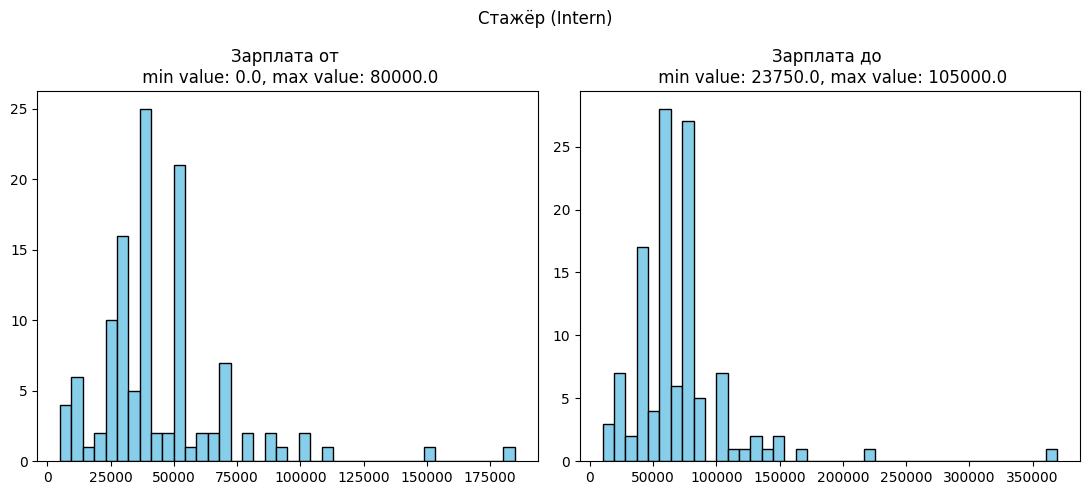

In [200]:
plt.figure(figsize=(11, 5))
plt.suptitle('Стажёр (Intern)')
plt.subplot(1, 2, 1)
_, minimum , maximum = find_outliers(df_exp[df_exp['Стаж'] == 'Стажёр (Intern)']['Зарплата от'], 1.5)
plt.title(f'Зарплата от \n min value: {minimum}, max value: {maximum}')
plt.hist(df_exp[df_exp['Стаж'] == 'Стажёр (Intern)']['Зарплата от'], bins=40, color='skyblue', edgecolor='black')

plt.subplot(1, 2, 2)
_, minimum , maximum = find_outliers(df_exp[df_exp['Стаж'] == 'Стажёр (Intern)']['Зарплата до'], 0.8)
plt.title(f'Зарплата до \n min value: {minimum}, max value: {maximum}')
plt.hist(df_exp[df_exp['Стаж'] == 'Стажёр (Intern)']['Зарплата до'], bins=40, color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

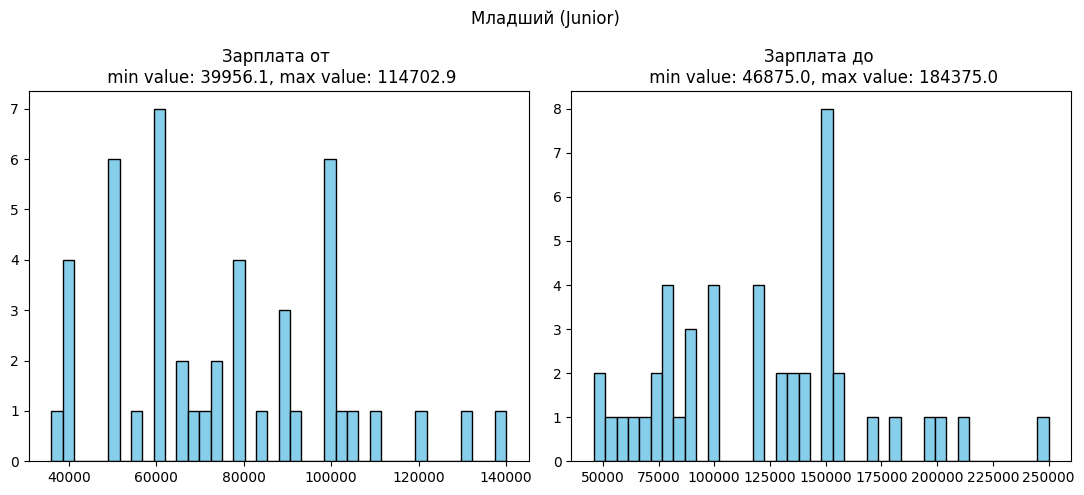

In [206]:
plt.figure(figsize=(11, 5))
plt.suptitle('Младший (Junior)')
plt.subplot(1, 2, 1)
_, minimum , maximum = find_outliers(df_exp[df_exp['Стаж'] == 'Младший (Junior)']['Зарплата от'], 0.4)
plt.title(f'Зарплата от \n min value: {minimum}, max value: {maximum}')
plt.hist(df_exp[df_exp['Стаж'] == 'Младший (Junior)']['Зарплата от'], bins=40, color='skyblue', edgecolor='black')

plt.subplot(1, 2, 2)
_, minimum , maximum = find_outliers(df_exp[df_exp['Стаж'] == 'Младший (Junior)']['Зарплата до'], 0.5)
plt.title(f'Зарплата до \n min value: {minimum}, max value: {maximum}')
plt.hist(df_exp[df_exp['Стаж'] == 'Младший (Junior)']['Зарплата до'], bins=40, color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

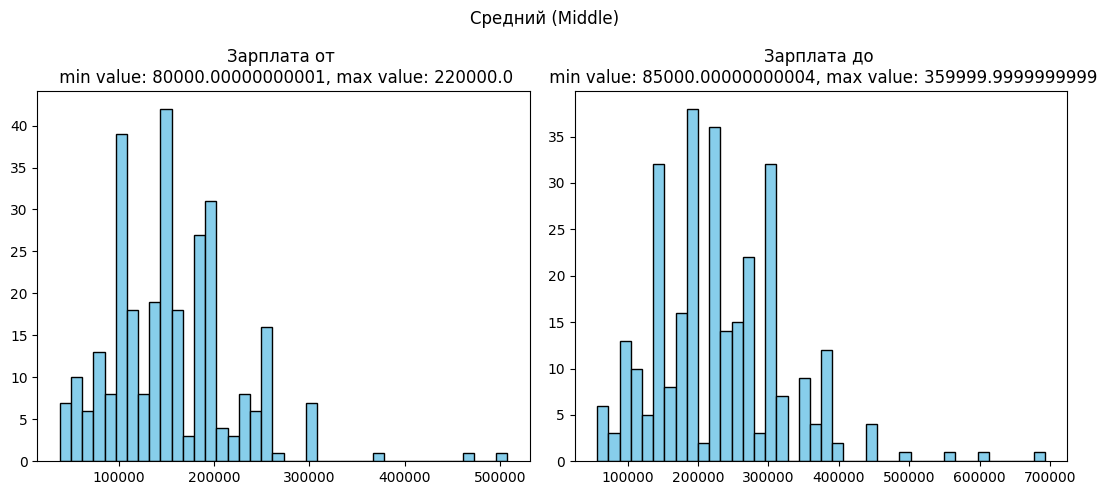

In [209]:
plt.figure(figsize=(11, 5))
plt.suptitle('Средний (Middle)')
plt.subplot(1, 2, 1)
_, minimum , maximum = find_outliers(df_exp[df_exp['Стаж'] == 'Средний (Middle)']['Зарплата от'], 0.2)
plt.title(f'Зарплата от \n min value: {minimum}, max value: {maximum}')
plt.hist(df_exp[df_exp['Стаж'] == 'Средний (Middle)']['Зарплата от'], bins=40, color='skyblue', edgecolor='black')

plt.subplot(1, 2, 2)
_, minimum , maximum = find_outliers(df_exp[df_exp['Стаж'] == 'Средний (Middle)']['Зарплата до'], 0.6)
plt.title(f'Зарплата до \n min value: {minimum}, max value: {maximum}')
plt.hist(df_exp[df_exp['Стаж'] == 'Средний (Middle)']['Зарплата до'], bins=40, color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

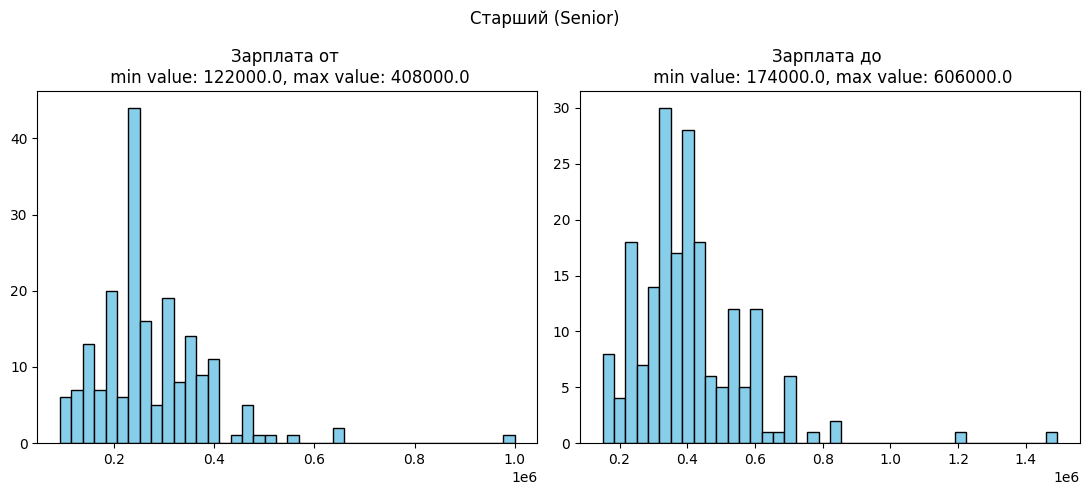

In [215]:
plt.figure(figsize=(11, 5))
plt.suptitle('Старший (Senior)')
plt.subplot(1, 2, 1)
_, minimum , maximum = find_outliers(df_exp[df_exp['Стаж'] == 'Старший (Senior)']['Зарплата от'], 0.6)
plt.title(f'Зарплата от \n min value: {minimum}, max value: {maximum}')
plt.hist(df_exp[df_exp['Стаж'] == 'Старший (Senior)']['Зарплата от'], bins=40, color='skyblue', edgecolor='black')

plt.subplot(1, 2, 2)
_, minimum , maximum = find_outliers(df_exp[df_exp['Стаж'] == 'Старший (Senior)']['Зарплата до'], 0.7)
plt.title(f'Зарплата до \n min value: {minimum}, max value: {maximum}')
plt.hist(df_exp[df_exp['Стаж'] == 'Старший (Senior)']['Зарплата до'], bins=40, color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

### Функционал для работы с выбросами

In [216]:
lower_bounds_l_wage = {'Стажёр (Intern)': find_outliers(df_exp[df_exp['Стаж'] == 'Стажёр (Intern)']['Зарплата от'], 1.5)[1],
                'Младший (Junior)': find_outliers(df_exp[df_exp['Стаж'] == 'Младший (Junior)']['Зарплата от'], 0.4)[1],
                'Средний (Middle)': find_outliers(df_exp[df_exp['Стаж'] == 'Средний (Middle)']['Зарплата от'], 0.2)[1],
                'Старший (Senior)': find_outliers(df_exp[df_exp['Стаж'] == 'Старший (Senior)']['Зарплата от'], 0.6)[1]}

upper_bounds_l_wage = {'Стажёр (Intern)': find_outliers(df_exp[df_exp['Стаж'] == 'Стажёр (Intern)']['Зарплата от'], 1.5)[2],
                'Младший (Junior)': find_outliers(df_exp[df_exp['Стаж'] == 'Младший (Junior)']['Зарплата от'], 0.4)[2],
                'Средний (Middle)': find_outliers(df_exp[df_exp['Стаж'] == 'Средний (Middle)']['Зарплата от'], 0.2)[2],
                'Старший (Senior)': find_outliers(df_exp[df_exp['Стаж'] == 'Старший (Senior)']['Зарплата от'], 0.6)[2]}

lower_bounds_u_wage = {'Стажёр (Intern)': find_outliers(df_exp[df_exp['Стаж'] == 'Стажёр (Intern)']['Зарплата до'], 0.8)[1],
                'Младший (Junior)': find_outliers(df_exp[df_exp['Стаж'] == 'Младший (Junior)']['Зарплата до'], 0.5)[1],
                'Средний (Middle)': find_outliers(df_exp[df_exp['Стаж'] == 'Средний (Middle)']['Зарплата до'], 0.6)[1],
                'Старший (Senior)': find_outliers(df_exp[df_exp['Стаж'] == 'Старший (Senior)']['Зарплата до'], 0.7)[1]}

upper_bounds_u_wage = {'Стажёр (Intern)': find_outliers(df_exp[df_exp['Стаж'] == 'Стажёр (Intern)']['Зарплата до'], 0.8)[2],
                'Младший (Junior)': find_outliers(df_exp[df_exp['Стаж'] == 'Младший (Junior)']['Зарплата до'], 0.5)[2],
                'Средний (Middle)': find_outliers(df_exp[df_exp['Стаж'] == 'Средний (Middle)']['Зарплата до'], 0.6)[2],
                'Старший (Senior)': find_outliers(df_exp[df_exp['Стаж'] == 'Старший (Senior)']['Зарплата до'], 0.7)[2]}

def get_soft_bounds(grade, lower_bounds_l_wage=lower_bounds_l_wage, lower_bounds_u_wage=lower_bounds_l_wage, upper_bounds_l_wage=upper_bounds_u_wage,
                    upper_bounds_u_wage=upper_bounds_u_wage, data=None):

    lower_bound_l_wage = lower_bounds_l_wage[grade]
    upper_bound_l_wage = upper_bounds_l_wage[grade]

    lower_bound_u_wage = lower_bounds_u_wage[grade]
    upper_bound_u_wage = upper_bounds_u_wage[grade]

    return lower_bound_l_wage, upper_bound_l_wage, lower_bound_u_wage, upper_bound_u_wage

In [217]:
def apply_bounds(df):
    dataset = df.copy()
    outlier_indexes = []

    for index, row in dataset.iterrows():
        l_wage, u_wage = row['Зарплата от'], row['Зарплата до']
        l_bound_l_wage, u_bound_l_wage, l_bound_u_wage, u_bound_u_wage = get_soft_bounds(row['Стаж'])
        if (l_bound_l_wage <= l_wage <= u_bound_l_wage) and (l_bound_u_wage <= u_wage <= u_bound_u_wage):
            continue

        is_outlier = True
        for grade in dataset['Стаж'].unique():
            l_bound_l_wage, u_bound_l_wage, l_bound_u_wage, u_bound_u_wage = get_soft_bounds(grade)
            if (l_bound_l_wage <= l_wage <= u_bound_l_wage) and (l_bound_u_wage <= u_wage <= u_bound_u_wage):
                dataset.loc[index, 'Стаж'] = grade
                is_outlier = False
                break
        if is_outlier:
            outlier_indexes += [index]
            dataset.drop(index=index, inplace=True)

    return dataset, outlier_indexes

### Применение функции для поиска выбросов и перевода несоответствующих стажей

In [218]:
df_salaries_bounded, outlier_indexes = apply_bounds(df_exp)
df_salaries_bounded

,Дата размещения,Вакансия,Стаж,Зарплата от,Зарплата до,Город,Дата сбора данных,Число сотрудников,Тип занятости,Можно удаленно
0,2024-06-27 16:50:48,Архитектор программного обеспечения,Старший (Senior),333333.333333,500000.0,Москва,2024-07-01 23:06:03,0,Полный рабочий день,Нет
2,2024-06-04 16:24:59,Менеджер проекта,Стажёр (Intern),5000.000000,25000.0,"Москва, Санкт-Петербург, Казань",2024-07-01 23:06:04,1,Полный рабочий день,Да
3,2024-07-01 12:09:30,Бэкенд разработчик,Средний (Middle),210000.000000,315000.0,Удаленно,2024-07-01 23:06:04,0,Полный рабочий день,Да
8,2024-06-04 09:23:18,Менеджер по найму,Стажёр (Intern),66666.666667,100000.0,Удаленно,2024-07-01 23:06:06,0,Полный рабочий день,Да
18,2024-06-06 13:34:21,Менеджер технической поддержки,Стажёр (Intern),60000.000000,90000.0,Удаленно,2024-07-01 23:06:10,0,Полный рабочий день,Да
...,...,...,...,...,...,...,...,...,...,...
3153,2024-07-01 13:29:52,Веб-разработчик,Средний (Middle),200000.000000,300000.0,Москва,2024-07-01 23:23:36,0,Полный рабочий день,Нет
3160,2024-06-03 15:46:09,Фулстек разработчик,Стажёр (Intern),40000.000000,60000.0,Москва,2024-07-01 23:23:39,1,Неполный рабочий день,Да
3176,2024-06-26 13:17:01,DevOps-инженер,Старший (Senior),400000.000000,600000.0,Удаленно,2024-07-01 23:23:44,0,Полный рабочий день,Да
3181,2024-06-27 10:06:33,Фулстек разработчик,Старший (Senior),300000.000000,450000.0,Екатеринбург,2024-07-01 23:23:45,0,Полный рабочий день,Нет


In [223]:
len(df_exp.loc[outlier_indexes])

17

In [220]:
df_salaries_bounded.groupby('Стаж').describe()

Зарплата от                                                   \
                       count           mean           std       min       25%   
Стаж                                                                            
Младший (Junior)        52.0   74118.169872  19409.237457   40000.0   60000.0   
Средний (Middle)       258.0  150303.357881  43916.663459   80000.0  110211.0   
Стажёр (Intern)        128.0   41465.317708  16552.111688    5000.0   30000.0   
Старший (Senior)       201.0  263078.515755  68964.555298  130000.0  225000.0   

                                               Зарплата до                 \
                       50%       75%       max       count           mean   
Стаж                                                                        
Младший (Junior)   74475.0   86250.0  120000.0        52.0  115527.230769   
Средний (Middle)  150000.0  180000.0  300000.0       258.0  222495.622093   
Стажёр (Intern)    40000.0   50000.0   80000.0       128.0   64940.898438   
Старший (Senior)  250000.0  300000.0  508035.0       201.0  394229.656716   

                  ...                      Число сотрудников            \
                  ...        75%       max             count      mean   
Стаж              ...                                                    
Младший (Junior)  ...  141416.25  180000.0              52.0  3.115385   
Средний (Middle)  ...  270000.00  350000.0             258.0  4.050388   
Стажёр (Intern)   ...   80000.00  105000.0             128.0  0.906250   
Старший (Senior)  ...  450000.00  600405.0             201.0  6.328358   

                                                        
                        std  min  25%  50%   75%   max  
Стаж                                                    
Младший (Junior)  11.720025  0.0  0.0  0.0  2.00  83.0  
Средний (Middle)  14.748520  0.0  0.0  0.0  1.75  83.0  
Стажёр (Intern)    2.318829  0.0  0.0  0.0  1.00  12.0  
Старший (Senior)  17.410676  0.0  0.0  0.0  6.00  83.0  

[4 rows x 24 columns]

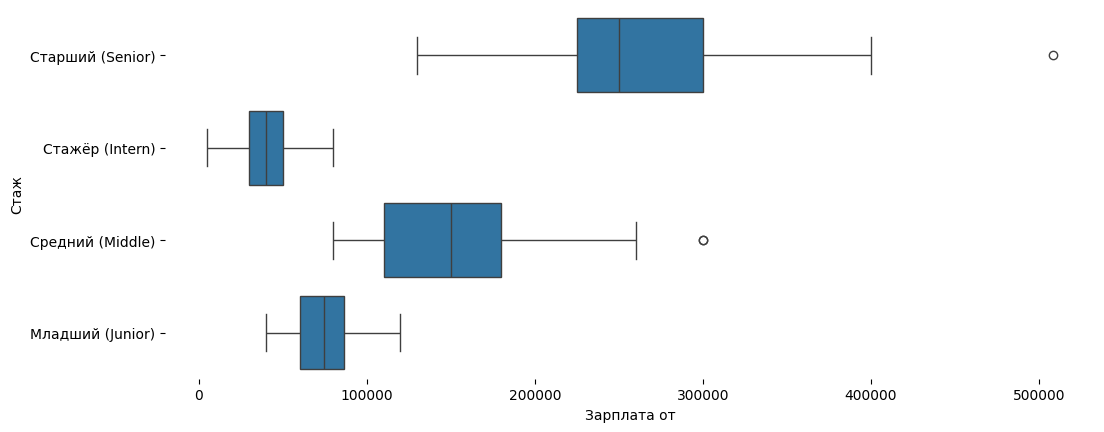

In [221]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_salaries_bounded['Стаж'].unique()))
plt.figure(figsize=figsize)
sns.boxplot(df_salaries_bounded, x='Зарплата от', y='Стаж')
sns.despine(top=True, right=True, bottom=True, left=True)

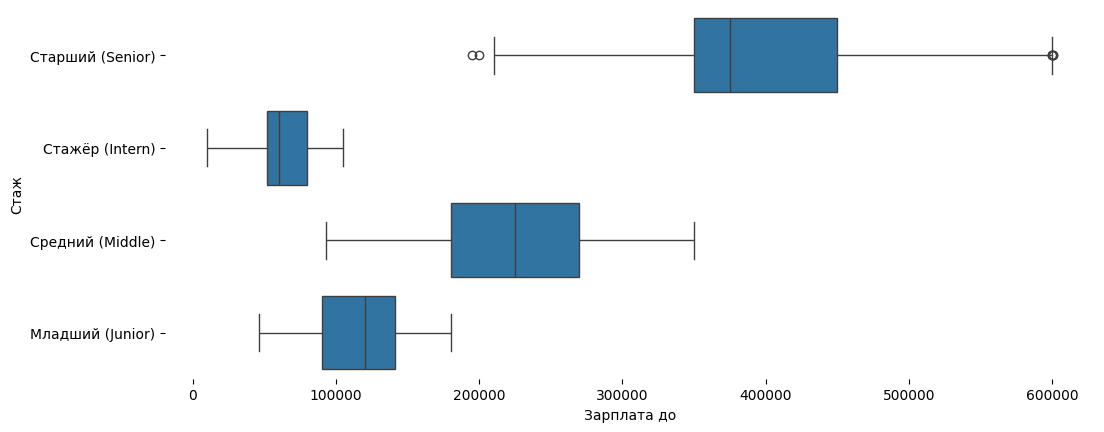

In [222]:
figsize = (12, 1.2 * len(df_salaries_bounded['Стаж'].unique()))
plt.figure(figsize=figsize)
sns.boxplot(df_salaries_bounded, x='Зарплата до', y='Стаж')
sns.despine(top=True, right=True, bottom=True, left=True)

In [224]:
df_outliers_salaries = df_exp.loc[outlier_indexes]
df_outliers_salaries

,Дата размещения,Вакансия,Стаж,Зарплата от,Зарплата до,Город,Дата сбора данных,Число сотрудников,Тип занятости,Можно удаленно
66,2024-07-01 13:34:02,Бэкенд разработчик,Старший (Senior),646590.0,831330.0,Удаленно,2024-07-01 23:06:26,0,Полный рабочий день,Да
280,2024-06-10 13:45:40,Бэкенд разработчик,Старший (Senior),400000.0,700000.0,Удаленно,2024-07-01 23:07:37,1,Полный рабочий день,Да
381,2024-06-30 08:09:25,Бэкенд разработчик,Старший (Senior),1000000.0,1200000.0,Удаленно,2024-07-01 23:08:11,0,Полный рабочий день,Да
511,2024-06-27 19:55:20,Бэкенд разработчик,Старший (Senior),461850.0,692775.0,Удаленно,2024-07-01 23:08:51,0,Полный рабочий день,Да
729,2024-06-12 13:37:21,Фулстек разработчик,Старший (Senior),447885.0,671827.5,Удаленно,2024-07-01 23:10:10,1,Полный рабочий день,Да
893,2024-06-13 00:33:37,Менеджер по продажам,Средний (Middle),50000.0,200000.0,"Екатеринбург, Нижний Новгород, Новосибирск",2024-07-01 23:11:04,0,Неполный рабочий день,Да
1111,2024-06-27 09:03:58,DevOps-инженер,Средний (Middle),461850.0,692775.0,"Новосибирск, Омск",2024-07-01 23:12:14,0,Полный рабочий день,Да
1459,2024-06-27 19:56:21,Фронтенд разработчик,Старший (Senior),461850.0,692775.0,Удаленно,2024-07-01 23:14:12,0,Полный рабочий день,Да
1689,2024-06-30 19:56:23,Ученый по данным,Старший (Senior),508035.0,762052.5,Удаленно,2024-07-01 23:15:28,0,Не указан,Да
1974,2024-06-29 11:17:16,Бэкенд разработчик,Старший (Senior),461850.0,692775.0,Удаленно,2024-07-01 23:17:07,0,Полный рабочий день,Да


In [225]:
df_outliers_salaries.groupby('Стаж').describe()

Зарплата от                                          \
                       count           mean            std       min   
Стаж                                                                   
Младший (Junior)         1.0   40000.000000            NaN   40000.0   
Средний (Middle)         3.0  190616.666667  234948.166269   50000.0   
Старший (Senior)        13.0  539247.692308  157044.387696  400000.0   

                                                          Зарплата до  \
                       25%       50%       75%        max       count   
Стаж                                                                    
Младший (Junior)   40000.0   40000.0   40000.0    40000.0         1.0   
Средний (Middle)   55000.0   60000.0  260925.0   461850.0         3.0   
Старший (Senior)  461850.0  461850.0  554220.0  1000000.0        13.0   

                                 ...                      Число сотрудников  \
                           mean  ...       75%        max             count   
Стаж                             ...                                          
Младший (Junior)  200000.000000  ...  200000.0   200000.0               1.0   
Средний (Middle)  397591.666667  ...  496387.5   692775.0               3.0   
Старший (Senior)  815381.153846  ...  831330.0  1492950.0              13.0   

                                                               
                      mean       std  min  25%  50%  75%  max  
Стаж                                                           
Младший (Junior)  0.000000       NaN  0.0  0.0  0.0  0.0  0.0  
Средний (Middle)  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
Старший (Senior)  0.153846  0.375534  0.0  0.0  0.0  0.0  1.0  

[3 rows x 24 columns]